# INTRO

- Name : Firman Syah
- Batch : BSD 007
- Objective : This project aims to predict the customer's sentiment from the starbucks' reviews.

# LIBRARY

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import re
import string

import warnings
warnings.filterwarnings("ignore")

!pip install emoji
import emoji
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.impute import SimpleImputer

!pip install tensorflow
!pip install keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

!pip install wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to /Users/firman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/firman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2024-09-10 13:29:12.153332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# DATA LOADING

In [2]:
# Load data from CSV and define as df
df_ori = pd.read_csv('reviews_data.csv')
df = df_ori.copy()
df.shape

(850, 6)

In [3]:
# Cek first 5 rows
df.head(5)

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


the example of data is shown above.

In [4]:
# Show the summary of data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


It can be seen that there is missing value in colum Rating.

In [5]:
# Checking missing value and make it in percentage
Nulls=round((df.isnull().sum())/len(df)*100,3)
Nulls.to_frame(name='Percentage of Nulls %')

,Percentage of Nulls %
name,0.000
location,0.000
Date,0.000
Rating,17.059
Review,0.000
Image_Links,0.000


The total of missing value is 17%. it is quite big, so I decide to fill the missing value with median

In [6]:
# Check the missing value in rating column
df['Rating'].isnull().sum()


145

there is 145 data ready to fill

In [8]:
# Filling missing value with median data

imputer = SimpleImputer(strategy='median')
df['Rating'] = imputer.fit_transform(df[['Rating']])
df['Rating'].value_counts()


Rating
1.0    596
2.0     99
5.0     83
4.0     39
3.0     33
Name: count, dtype: int64

The missing values have been filled and it is the data distribution of rating.

In [9]:
# Check after filling missing value
df['Rating'].isnull().sum()


0

handling missing value is done

# EDA

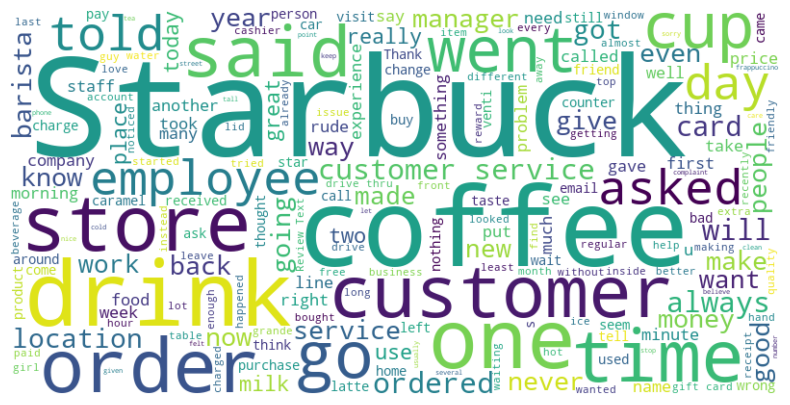

In [10]:
# Making word cloud
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Review']))

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


From the cloud, we can see that starbuck, drink, coffee, store are the most frequent word on the review. It depics that most of customer share their experience while having dine-in service.

<Axes: xlabel='Rating', ylabel='count'>

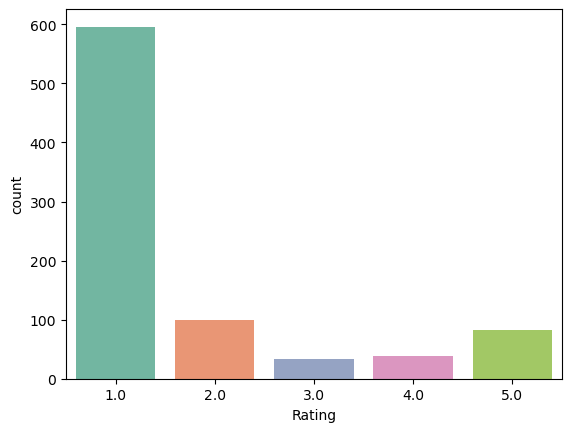

In [11]:
# visualize the data distribution each category
sns.countplot(x="Rating",data=df, palette="Set2")

<Axes: ylabel='count'>

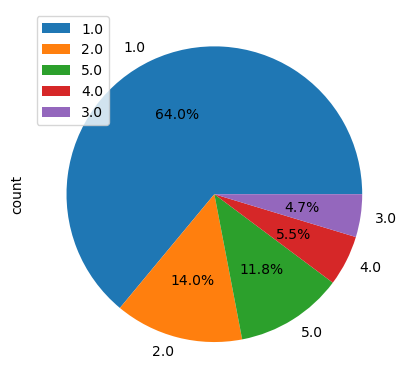

In [12]:
# Distribution of rating in each category in pie chart show legend
df_ori["Rating"].value_counts().plot.pie(autopct='%1.1f%%',legend=True)


More than a half of the reviews are rated in the lowest value. It indicates that Starbucks should take into account of custumer's satisfaction.

<Axes: ylabel='location'>

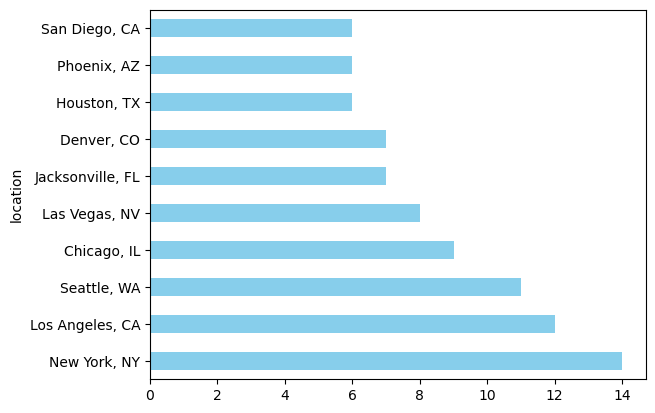

In [13]:
# check most location of review
df_ori["location"].value_counts().head(10).plot(kind='barh', color='skyblue')

NY is the most region that has highest participant of the review. we will elaborate the reviews in 2 big locations in the next step.

<Axes: xlabel='location'>

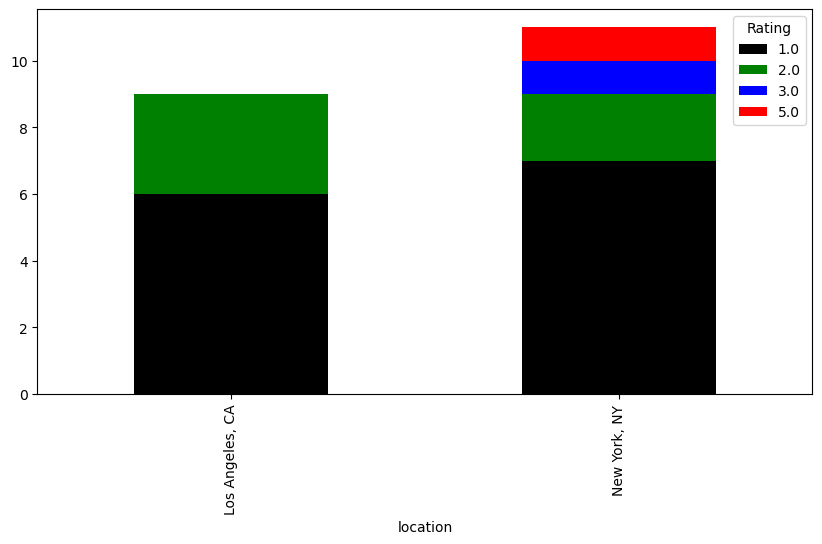

In [14]:
# Take 3 location with most review, show the distribution of rating in each location in bar chart
df_ori[df_ori["location"].isin(["New York, NY","Los Angeles, CA","Seatle, WA"])].groupby(["location","Rating"]).size().unstack().plot(kind='bar',stacked=True, color=['black','green','blue','red','orange'], figsize=(10,5))


By this chart, we can see that in LA, there is no good review unlike in NY. Starbucks should be more active to evaluate the service in stores there.

# FEATURE ENGINEERING

In [15]:
# classifying rating 1-2 as Negative (2)
df["Rating"]=df["Rating"].replace([1,2],2)
# classifying rating 3 as Neutral (0)
df["Rating"]=df["Rating"].replace(3,0)
# classifying rating 4-5 as Positive (1)
df["Rating"]=df["Rating"].replace([3,4,5],1)
# Drop missing value and change them as integer
df = df.dropna(axis = 0, how ='any')
df["Rating"]=df["Rating"].astype(int)

In [16]:
# Show number of each sentiments
df["Rating"].value_counts()

Rating
2    695
1    122
0     33
Name: count, dtype: int64

the distribution shows above

In [17]:
# Define DF as 2 column we will use in the model
df = df[["Review","Rating"]]

In [18]:
# Making cleaning funcion
def cleaning (text):
    text = re.sub('[^a-zA-Z]', ' ', str(text).lower().strip())
    text = re.sub('@[A-Za-z0-9_]+', '', text)
    text = re.sub('#','',text)
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text)
    text = re.sub('\n',' ',text)
    text = emoji.replace_emoji(text, replace='')
    return text

# Apply cleaning function into dataframe
df["Review"] = df["Review"].apply(cleaning)



In [19]:
# Making function for lemmatization process and apply it into dataframe
def lemm(data):
    wordnet = WordNetLemmatizer()
    lemmanized = []
    for i in range(len(data)):
        lemmed = []
        words = word_tokenize(data['Review'].iloc[i])
        for w in words:
            lemmed.append(wordnet.lemmatize(w))
        lemmanized.append(lemmed)

    data['lemmanized'] = lemmanized
    data['Review'] = data['lemmanized'].apply(' '.join)
    data=data.drop("lemmanized",axis=1)
    return data

# define df as df processed bylemm function into
df=lemm(df)

In [20]:
#Split the data into X and Y (train and test) with portion 80:20
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2, random_state=42)

In [21]:

# Tokenizer from keras with max 10000 words
tokenizer = Tokenizer(num_words=10000)
# fit the tokenizer on X train
tokenizer.fit_on_texts(X_train)
# Convert the X train tokenized into sequence Integer
X_train = tokenizer.texts_to_sequences(X_train)
# Convert the X test tokenized into sequence Integer
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
# Pad the sequences
# making maximum len is 50 and if the any under 50 will be padded to 50 with 0
X_train = pad_sequences(X_train, maxlen=50)
X_test = pad_sequences(X_test, maxlen=50)

In [23]:
# Convert the labels to categorical values
# With one-hot encoding
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# MODEL

In [24]:
# Create Sequential Model
model = Sequential()
# Add Embedding with 10000 unique words, 20 dimentionality space, max lenght input
model.add(Embedding(10000, 200, input_length=50))
# Add layer DO to minimize overfitting with 40% rate
model.add(SpatialDropout1D(0.4))
# Add LMST with 40% rate of connection
model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))
# Add dense with 100 layer and activation function RELU
model.add(Dense(100, activation='relu'))
# Add dense with 5 outputs with AF softmax
model.add(Dense(5, activation='softmax'))
# Compile all model above with loss func CC, adam as optimizer, accuracy and metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# define early stop within 5 epoch no improvement
early_stopping_monitor = EarlyStopping(patience=5)


In [25]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128, callbacks=[early_stopping_monitor])

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 452ms/step - accuracy: 0.6337 - loss: 1.5731 - val_accuracy: 0.7588 - val_loss: 1.3813
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - accuracy: 0.8311 - loss: 1.1629 - val_accuracy: 0.7588 - val_loss: 1.2916
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - accuracy: 0.8361 - loss: 0.7681 - val_accuracy: 0.7588 - val_loss: 0.8202
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.8243 - loss: 0.6197 - val_accuracy: 0.7588 - val_loss: 0.6625
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.8530 - loss: 0.5519 - val_accuracy: 0.7588 - val_loss: 0.6764
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.8215 - loss: 0.5610 - val_accuracy: 0.7588 - val_loss: 0.6924
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.8367 - loss: 0.5245 - val_accuracy: 0.7588 - val_loss: 0.6871
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.8298 - loss: 0.5355 - val_accuracy: 0.7588 - val_loss:

In [26]:
# Predict to the X-test data
y_pred_prob = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


In [27]:
# Apply the predict as y pred
y_pred = np.argmax(y_pred_prob, axis=1)

In [28]:
# exctract the true label and macth with the OHE
y_true = np.argmax(y_test, axis=1)

In [29]:
# Check the accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8235294117647058


The accuracy of the base model is 82% which is classified as a good one.

In [30]:
# Print the calssification report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.81      0.36      0.50        36
           2       0.82      0.98      0.90       129

    accuracy                           0.82       170
   macro avg       0.55      0.45      0.47       170
weighted avg       0.80      0.82      0.79       170



Even though the accuracy in general is good. in class neutral, the model can not predict that target.

In [38]:
# compare accuracy between train and test
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


Train: 0.956, Test: 0.824


This shows that the model is overfit because gap of the train and test is quite far.

# MODEL IMPROVEMENT

In [31]:
# Define model 2 with 3 hidden layer
model2 = Sequential()
model2.add(Embedding(10000, 200, input_length=50))
model2.add(SpatialDropout1D(0.4))
model2.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(5, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=5)

In [32]:
# Train the model
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128, callbacks=[early_stopping_monitor])

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.5377 - loss: 1.5910 - val_accuracy: 0.7588 - val_loss: 1.4777
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.8415 - loss: 1.3053 - val_accuracy: 0.7588 - val_loss: 0.9133
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.8330 - loss: 0.6658 - val_accuracy: 0.7588 - val_loss: 0.7246
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.8227 - loss: 0.5826 - val_accuracy: 0.7588 - val_loss: 0.6439
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.8362 - loss: 0.5642 - val_accuracy: 0.7588 - val_loss: 0.7067
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.8414 - loss: 0.5380 - val_accuracy: 0.7588 - val_loss: 0.6739
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.8458 - loss: 0.4994 - val_accuracy: 0.7588 - val_loss: 0.6495
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.8311 - loss: 0.5251 - val_accuracy: 0.7588 - val_loss:

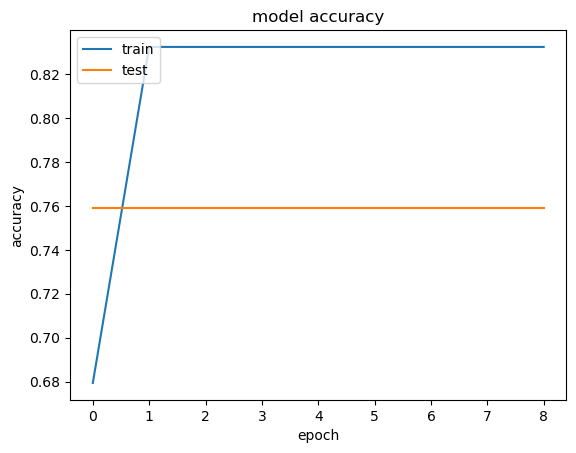

In [33]:
# Show learning curve
plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


it can be seen that the gap of accuracy in test and train data is far. So it will be a note as a future improvement.

In [34]:
# Predict to the X-test data
y_pred_prob = model2.predict(X_test)

# Apply the predict as y pred
y_pred = np.argmax(y_pred_prob, axis=1)

# exctract the true label and macth with the OHE
y_true = np.argmax(y_test, axis=1)

# Check the accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Accuracy: 0.7588235294117647


the accuracy is declining.

In [35]:
# Compare the accuracy between test and train data
train_loss, train_acc = model2.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


Train: 0.832, Test: 0.759


the gap of test and train accuracy score is to far and it is classified overfitting.

In [36]:
# show the classification report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        36
           2       0.76      1.00      0.86       129

    accuracy                           0.76       170
   macro avg       0.25      0.33      0.29       170
weighted avg       0.58      0.76      0.65       170



After we do an improvment, the train score drops. So we decide to use model 1 as the model we use in inference.

# Saving Model

In [39]:
# Saving the model
model.save('model.h5')
print("Model Saved")

# save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer Saved")




Model Saved
Tokenizer Saved


# CONCLUSION

- EDA : To wrap up, most of the reviews are in the negative sentiment which is 64% of the total data. While NY takes the bigget state of contribution of it. The review tells about the products and services, it can be seen that the most words mentioned are coffee, store, and order.

- MODEL : The model 1 has 82 accuracy score. After we conducted model 2 that aims to improve by adding the hidden layers, the result shows that the accuracy drops. So we decided to take model 1 as the model to be used in the infrence section. However, looking at the model performance, the model 1 can not predict the neutral sentiment and the model categorized as over fitting because the score's gap is to far.

- Model Advantage : It has good accuracy in general
- Model Disadvantage : It can not predict the neutral sentiment

- ADD : To improve the model in the future, we suggest to add regularisation and augmentation to remedy the overfitting. To answer the neutral predict failure, handling imbalance so the data each class becoming balance.

- Note : The model summaries are in the picture attached. it is because the results crushed after repeat run all.